In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from github import Github, Label
from pprint import pprint

In [131]:
# ==========================================
# DONT FORGET TO INSERT CREDENTIALS
# ==========================================
g = Github("", "")
repo = g.get_repo("CleverRaven/Cataclysm-DDA")
#open_issues = repo.get_issues(state='open')
#closed_issues = repo.get_issues(state='closed')
issues = repo.get_issues(state='all')

In [100]:
data = []
comment_data = []

In [101]:
def check_labels(issue, label_string):
    for label in issue.labels:
        if label.name == label_string:
            bug_label = label
            return True
    return False

In [102]:
# use a counter to track progress
counter = 0

# Pull Requests also count as Issues, so expected duration should be 
# around 15000
for issue in issues:
    # take issues only with [BUG] label
    if check_labels(issue, "Bug"):
        for label in issue.labels:
            data.append([issue.id, label.name, issue.comments])
            
    # Take all issues, labels and comments
    for label in issue.labels:
        comment_data.append([issue.id, label.name, issue.comments])
        
    counter += 1
    if counter % 50 == 0:
        print("Done pass %d" % counter)



Done pass 50
Done pass 100
Done pass 150
Done pass 200
Done pass 250
Done pass 300
Done pass 350
Done pass 400
Done pass 450
Done pass 500
Done pass 550
Done pass 600
Done pass 650
Done pass 700
Done pass 750
Done pass 800
Done pass 850
Done pass 900
Done pass 950
Done pass 1000
Done pass 1050
Done pass 1100
Done pass 1150
Done pass 1200
Done pass 1250
Done pass 1300
Done pass 1350
Done pass 1400
Done pass 1450
Done pass 1500
Done pass 1550
Done pass 1600
Done pass 1650
Done pass 1700
Done pass 1750
Done pass 1800
Done pass 1850
Done pass 1900
Done pass 1950
Done pass 2000
Done pass 2050
Done pass 2100
Done pass 2150
Done pass 2200
Done pass 2250
Done pass 2300
Done pass 2350
Done pass 2400
Done pass 2450
Done pass 2500
Done pass 2550
Done pass 2600
Done pass 2650
Done pass 2700
Done pass 2750
Done pass 2800
Done pass 2850
Done pass 2900
Done pass 2950
Done pass 3000
Done pass 3050
Done pass 3100
Done pass 3150
Done pass 3200
Done pass 3250
Done pass 3300
Done pass 3350
Done pass 3400


KeyboardInterrupt: 

In [105]:
df = pd.DataFrame(data)
df.columns=["id", "label", "comments"]
df.head(5)

,id,label,comments
0,285666680,Bug,0
1,284308179,Bug,0
2,284308179,NPC,0
3,284299542,Bug,3
4,284299542,Confirmed,3


In [150]:
df.groupby(['label']).count()
df.groupby(['label']).sum()

agg = pd.DataFrame(df.groupby(['label']).count())
agg.comments = df.groupby(['label']).sum()['comments']
agg.colums = ["label", "issues", "comments"]
agg = agg.drop(['Bug', 'Confirmed', 'Confirmation Needed'])

In [151]:
agg.sort_values('id', ascending=False).head(10)

,id,comments
label,,
Information / Interface,106,345
Vehicle,70,345
NPC,55,130
Crafting / Construction,40,148
Easy-fix,36,97
Mapgen,34,165
Duplicate,26,70
Mission,23,58
Mods,21,83


In [128]:
# normalize, not sure if we need it!
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(agg)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.index = agg.index
df_normalized.columns = agg.columns
df_normalized.sort_values('id', ascending=False)

,id,comments
label,,
Information / Interface,1.000000,1.000000
Vehicle,0.657143,1.000000
NPC,0.514286,0.373178
Crafting / Construction,0.371429,0.425656
Easy-fix,0.333333,0.276968
Mapgen,0.314286,0.475219
Duplicate,0.238095,0.198251
Mission,0.209524,0.163265
Mods,0.190476,0.236152


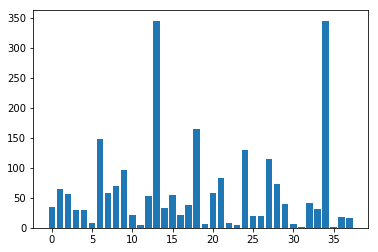

In [145]:
plt.bar([i for i in range(len(agg.index))], agg['comments'])
plt.show()

In [152]:
# Save to csv
df.to_csv("issue_data.csv")